# Recognize device

In [ ]:
import torch

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cpu


# Read data file 

### Prepare traing data Excel file:
### N=100, x1=NORM.INV(RAND(),0,1), x2=NORM.INV(RAND(),5,2) => y=0
### N=100, x1=NORM.INV(RAND(),0.8,1), x2=NORM.INV(RAND(),3,1.5) => y=1

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving classification training data.xlsx to classification training data (1).xlsx


In [ ]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

classification training data.xlsx


In [ ]:
import pandas as pd
df=pd.read_excel(fname)

In [ ]:
df.head(5)

,x1,x2,y
0,-0.343282,9.307780,0
1,0.714918,7.443227,0
2,0.395074,6.325097,0
3,1.456979,2.372324,0
4,-0.242929,6.328100,0


In [ ]:
df.tail(5)

,x1,x2,y
195,1.095324,1.659427,1
196,0.844242,1.289458,1
197,0.745665,2.399733,1
198,-1.262625,2.852539,1
199,0.311653,1.845815,1


In [ ]:
df.columns

Index(['x1', 'x2', 'y'], dtype='object')

# Visualize input data

In [ ]:
import matplotlib.pyplot as plt

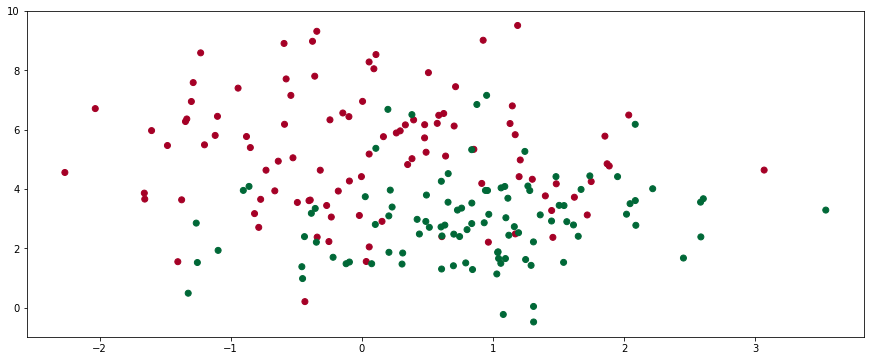

In [ ]:
lstX1 = df['x1'].values.tolist()  
lstX2 = df['x2'].values.tolist()
lstY = df['y'].values.tolist()
plt.figure(figsize=(15, 6))
plt.scatter(lstX1, lstX2, c=lstY, cmap='RdYlGn')
plt.show()

# Split input data to train vs test set

In [ ]:
import numpy as np

In [ ]:
dfY = df['y']
Y = np.array(dfY.values)

In [ ]:
dfX = df[['x1', "x2"]]
X = np.array(dfX.values)
dfY = df['y']
Y = np.array(dfY.values)
Y = Y.reshape(Y.shape[0], 1)
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [ ]:
# Split the dataset to trainand test data
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.20, random_state=0)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(160, 2) (40, 2) (160, 1) (40, 1)


# Create mini-batches for training data

In [ ]:
tensorX = torch.FloatTensor(trainX).to(device)
tensorY = torch.LongTensor(trainY).to(device)

In [ ]:
import torch.utils.data as Data

torch_dataset = Data.TensorDataset(tensorX, tensorY)

# Build NN

In [ ]:
import torch.nn as nn

In [ ]:
MyNet = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 15),
    nn.Tanh(),
    nn.Linear(15, 2),
)
MyNet.to(device)
print(MyNet)

Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): Tanh()
  (2): Linear(in_features=30, out_features=15, bias=True)
  (3): Tanh()
  (4): Linear(in_features=15, out_features=2, bias=True)
)


In [ ]:
# save the initial model parameters of this un-trained NN for later use
torch.save(MyNet.state_dict(), "InitialWeights.dat")

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.05)

# take one batch of size 5, pass to NN

In [ ]:
# set batch size = 5 for easy understanding purpose
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size= 5,               # mini batch size
    shuffle=True,               # random shuffle for training
    num_workers=2,              # subprocesses for loading data
)

In [ ]:
for batchX, batchY in loader:
    break
print(batchX,"\n", batchY)

tensor([[ 0.3951,  6.3251],
        [-0.3848,  3.1824],
        [ 2.0897,  2.7784],
        [ 1.6141,  2.7903],
        [ 2.0355,  6.4893]]) 
 tensor([[0],
        [1],
        [1],
        [1],
        [0]])


In [ ]:
batchY = torch.squeeze(batchY, dim=1)
print(batchY)

tensor([0, 1, 1, 1, 0])


In [ ]:
tensorY1 = MyNet(batchX)
print(tensorY1)

tensor([[-0.1818,  0.0798],
        [-0.0977,  0.0262],
        [ 0.2614,  0.1125],
        [ 0.1859,  0.0892],
        [-0.0470,  0.0917]], grad_fn=<AddmmBackward>)


In [ ]:
tensorY1 = torch.softmax(tensorY1, 1)
print(tensorY1)

tensor([[0.4350, 0.5650],
        [0.4691, 0.5309],
        [0.5372, 0.4628],
        [0.5242, 0.4758],
        [0.4654, 0.5346]], grad_fn=<SoftmaxBackward>)


In [ ]:
loss = loss_func(tensorY1, batchY)
print(float(loss))

0.7199898958206177


In [ ]:
# torch.max (.., 1) 1: 取每個 row 的最大值
MaxOfEachRow = torch.max(tensorY1, 1)
print(MaxOfEachRow)

torch.return_types.max(
values=tensor([0.5650, 0.5309, 0.5372, 0.5242, 0.5346], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 0, 0, 1]))


In [ ]:
# 計算 accuracy
correct = 0
MaxIdxOfEachRow = torch.max(tensorY1, 1)[1]
for i in range(batchY.shape[0]):
    print(int(MaxIdxOfEachRow[i]), int(batchY[i]))
    if (int(MaxIdxOfEachRow[i]) == int(batchY[i])):
            correct += 1
print(correct)
accuracy = correct/batchY.shape[0]
print("%.2f" % accuracy)

1 0
1 1
0 1
0 1
1 0
1
0.20


# Training Loop

In [ ]:
# train using training data
EpochLossLst = []
for epoch in range(1, 10):
  EpochLoss = 0
  for step, (batchX, batchY) in enumerate(loader): 
    batchY = torch.squeeze(batchY, dim=1)
    tensorY1 = MyNet(batchX)
    tensorY1 = torch.softmax(tensorY1, 1)
    loss = loss_func(tensorY1, batchY)
    EpochLoss += float(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    MaxIdxOfEachRow = torch.max(tensorY1, 1)[1]
    correct = 0
    for i in range(batchY.shape[0]):
      if (int(MaxIdxOfEachRow[i]) == int(batchY[i])):
        correct += 1  
    accuracy = correct/batchY.shape[0]
  EpochLoss = EpochLoss/(step+1)
  EpochLossLst.append(EpochLoss)

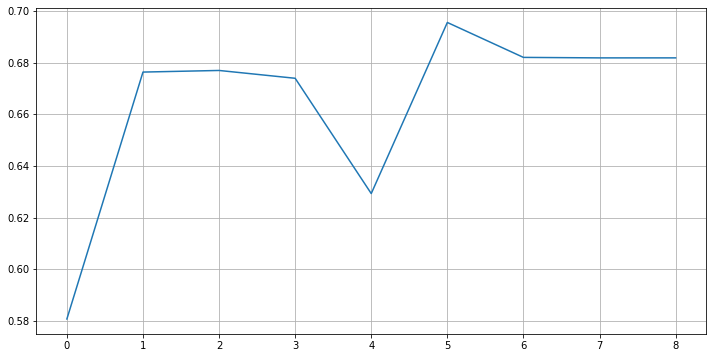

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(EpochLossLst)
plt.grid()
plt.show()

# 測試訓練結果

In [ ]:
tensorX = torch.FloatTensor(testX).to(device)
tensorY = torch.LongTensor(testY).to(device)
tensorY = torch.squeeze(tensorY, dim=1)
tensorY1 = MyNet(tensorX)
tensorY1 = torch.softmax(tensorY1, 1)
loss = loss_func(tensorY1, tensorY)
print(loss)

tensor(0.6624, grad_fn=<NllLossBackward>)


In [ ]:
tensorY

tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1])

In [ ]:
MaxIdxOfEachRow = torch.max(tensorY1, 1)[1]
print(MaxIdxOfEachRow)

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1])


In [ ]:
correct = 0
for i in range(tensorY.shape[0]):
    if (int(MaxIdxOfEachRow[i]) == int(tensorY[i])):
        correct += 1  
accuracy = correct/tensorY.shape[0]
print(accuracy)

0.65


# Randomly shuffle and split N times and see performance

In [ ]:
dfX = df[['x1', 'x2']]
dfY = df['y']
X = np.array(dfX.values)
Y = np.array(dfY.values)
Y = Y.reshape(Y.shape[0], 1)
AccuracyLst = []
for i in range(1, 11):
  print("\nIteration =", i, end = " ")
  trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.FloatTensor(trainY).to(device)
  MyNet.load_state_dict(torch.load('InitialWeights.dat')) #大家都用一樣的起始直
  print("epoch: ", end =" ")
  for epoch in range(1, 6):
    print(epoch, end = ",")
    for step, (batchX, batchY) in enumerate(loader): 
      batchY = torch.squeeze(batchY, dim=1)
      tensorY1 = MyNet(batchX)
      tensorY1 = torch.softmax(tensorY1, 1)
      loss = loss_func(tensorY1, batchY)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
  # test using test data
  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.LongTensor(testY).to(device)
  tensorY = torch.squeeze(tensorY, dim=1)
  tensorY1 = MyNet(tensorX)
  tensorY1 = torch.softmax(tensorY1, 1)
  MaxIdxOfEachRow = torch.max(tensorY1, 1)[1]
  correct = 0
  for i in range(tensorY.shape[0]):
    if (int(MaxIdxOfEachRow[i]) == int(tensorY[i])):
      correct += 1  
  accuracy = correct/tensorY.shape[0]
  AccuracyLst.append(accuracy)


Iteration = 1 epoch:  1,2,3,4,5,
Iteration = 2 epoch:  1,2,3,4,5,
Iteration = 3 epoch:  1,2,3,4,5,
Iteration = 4 epoch:  1,2,3,4,5,
Iteration = 5 epoch:  1,2,3,4,5,
Iteration = 6 epoch:  1,2,3,4,5,
Iteration = 7 epoch:  1,2,3,4,5,
Iteration = 8 epoch:  1,2,3,4,5,
Iteration = 9 epoch:  1,2,3,4,5,
Iteration = 10 epoch:  1,2,3,4,5,

In [ ]:
AccuracyLst

[0.7, 0.7, 0.55, 0.725, 0.45, 0.675, 0.75, 0.625, 0.55, 0.55]

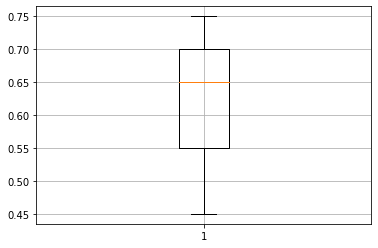

In [ ]:
plt.boxplot(AccuracyLst)
plt.grid()
plt.show()